# 산탄데르 고객 만족 예측

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
train_df = pd.read_csv('./data/santander-customer-satisfaction/train.csv')
test_df = pd.read_csv('./data/santander-customer-satisfaction/test.csv')

display(train_df.info())
display(train_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


None

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [5]:
print(train_df['TARGET'].value_counts())
print(train_df['TARGET'].value_counts(normalize=True))

TARGET
0    73012
1     3008
Name: count, dtype: int64
TARGET
0    0.960431
1    0.039569
Name: proportion, dtype: float64


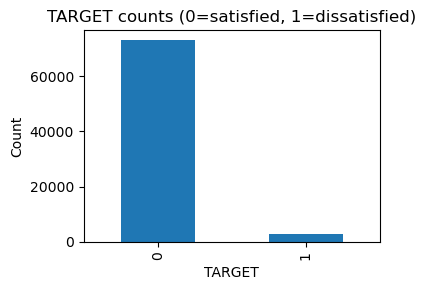

In [6]:
plt.figure(figsize=(4,3))
train_df['TARGET'].value_counts().sort_index().plot(kind='bar')
plt.title('TARGET counts (0=satisfied, 1=dissatisfied)')
plt.xlabel('TARGET')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [7]:
train_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [8]:
sentinel = -999999
train_median = train_df.loc[train_df['var3'] != sentinel, 'var3'].median()

for df, name in ((train_df, 'train'), (test_df, 'test')):
    mask = (df['var3'] == sentinel)
    if mask.any():
        df.loc[mask, 'var3'] = train_median
        print(f"{name}: replaced {mask.sum()} sentinel(s) with median {train_median}")

train: replaced 116 sentinel(s) with median 2.0
test: replaced 120 sentinel(s) with median 2.0


In [11]:
nunique = train_df.nunique(dropna=False)
const_cols = nunique[nunique == 1].index.tolist()

print(f"Constant features in train: {len(const_cols)} -> {const_cols[:10]}{'...' if len(const_cols)>10 else ''}")

Constant features in train: 34 -> ['ind_var2_0', 'ind_var2', 'ind_var27_0', 'ind_var28_0', 'ind_var28', 'ind_var27', 'ind_var41', 'ind_var46_0', 'ind_var46', 'num_var27_0']...


In [12]:
def find_duplicate_columns(df: pd.DataFrame):
    duplicates = []
    seen = {}
    for col in df.columns:
        col_data = df[col].values.tobytes()
        if col_data in seen:
            duplicates.append(col)
        else:
            seen[col_data] = col
    return duplicates

dup_cols = find_duplicate_columns(train_df.drop(columns=['TARGET']))
print(f"Duplicate columns: {len(dup_cols)} -> {dup_cols[:10]}{'...' if len(dup_cols)>10 else ''}")

Duplicate columns: 62 -> ['ind_var2', 'ind_var13_medio', 'ind_var18', 'ind_var26', 'ind_var25', 'ind_var27_0', 'ind_var28_0', 'ind_var28', 'ind_var27', 'ind_var29_0']...


In [13]:
X = train_df.drop(columns=['TARGET'])
y = train_df['TARGET']

X = X.drop(columns=const_cols, errors='ignore')
X = X.drop(columns=dup_cols, errors='ignore')
X_test = test_df.drop(columns=const_cols, errors='ignore')
X_test = test_df.drop(columns=dup_cols, errors='ignore')

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train/Valid shapes:', X_train.shape, X_valid.shape)

Train/Valid shapes: (60816, 307) (15204, 307)


In [14]:
num_features = X.columns.tolist()
num_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                  ('var_thresh', VarianceThreshold(threshold=0.0))]) 

preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_features)],
                                 remainder='drop')

In [15]:
def evaluate_model(name: str, model, X_tr, y_tr, X_va, y_va):
    model.fit(X_tr, y_tr)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_va)[:, 1]
    else:
        if hasattr(model, 'decision_function'):
            scores = model.decision_function(X_va)
            scores = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)
            y_proba = scores
        else:
            y_proba = model.predict(X_va)

    y_pred = (y_proba >= 0.5).astype(int)
    roc = roc_auc_score(y_va, y_proba)
    prauc = average_precision_score(y_va, y_proba)
    cm = confusion_matrix(y_va, y_pred)

    print(f'[{name}] ROC-AUC: {roc:.4f} | PR-AUC: {prauc:.4f}')
    print('Confusion Matrix:\n', cm)
    print(classification_report(y_va, y_pred, digits=4))

    return {'name': name, 'roc_auc': roc, 'pr_auc': prauc, 'model': model}

In [16]:
def plot_pr_curve(y_true, y_proba, label: str):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    plt.figure(figsize=(5,4))
    plt.plot(recall, precision, label=f'{label} (AP={ap:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

[LogReg] ROC-AUC: 0.8031 | PR-AUC: 0.1321
Confusion Matrix:
 [[9947 4655]
 [ 139  463]]
              precision    recall  f1-score   support

           0     0.9862    0.6812    0.8058     14602
           1     0.0905    0.7691    0.1619       602

    accuracy                         0.6847     15204
   macro avg     0.5383    0.7252    0.4839     15204
weighted avg     0.9508    0.6847    0.7803     15204



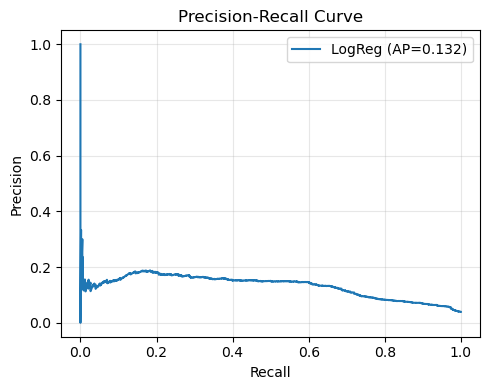

[SVM_RBF] ROC-AUC: 0.5275 | PR-AUC: 0.0481
Confusion Matrix:
 [[14601     1]
 [  601     1]]
              precision    recall  f1-score   support

           0     0.9605    0.9999    0.9798     14602
           1     0.5000    0.0017    0.0033       602

    accuracy                         0.9604     15204
   macro avg     0.7302    0.5008    0.4916     15204
weighted avg     0.9422    0.9604    0.9411     15204



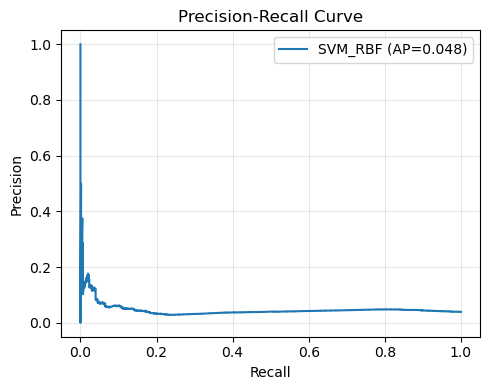

[GaussianNB] ROC-AUC: 0.5240 | PR-AUC: 0.0415
Confusion Matrix:
 [[  822 13780]
 [    6   596]]
              precision    recall  f1-score   support

           0     0.9928    0.0563    0.1065     14602
           1     0.0415    0.9900    0.0796       602

    accuracy                         0.0933     15204
   macro avg     0.5171    0.5232    0.0931     15204
weighted avg     0.9551    0.0933    0.1055     15204



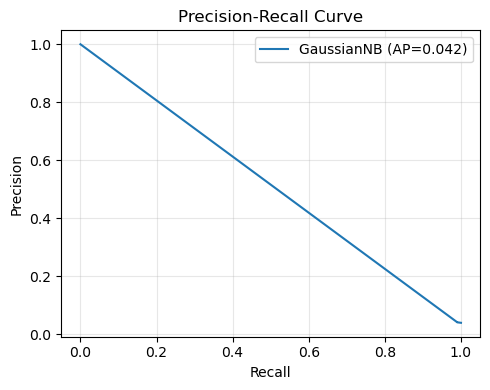

[KNN] ROC-AUC: 0.7723 | PR-AUC: 0.1388
Confusion Matrix:
 [[14596     6]
 [  599     3]]
              precision    recall  f1-score   support

           0     0.9606    0.9996    0.9797     14602
           1     0.3333    0.0050    0.0098       602

    accuracy                         0.9602     15204
   macro avg     0.6470    0.5023    0.4948     15204
weighted avg     0.9357    0.9602    0.9413     15204



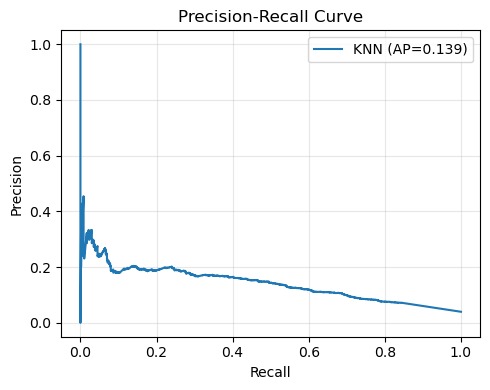

[DecisionTree] ROC-AUC: 0.5781 | PR-AUC: 0.0600
Confusion Matrix:
 [[13544  1058]
 [  465   137]]
              precision    recall  f1-score   support

           0     0.9668    0.9275    0.9468     14602
           1     0.1146    0.2276    0.1525       602

    accuracy                         0.8998     15204
   macro avg     0.5407    0.5776    0.5496     15204
weighted avg     0.9331    0.8998    0.9153     15204



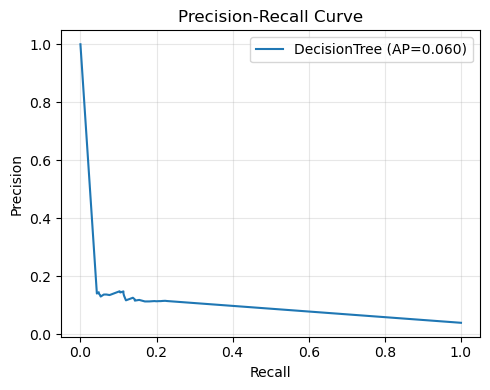

[RandomForest] ROC-AUC: 0.7992 | PR-AUC: 0.1581
Confusion Matrix:
 [[13099  1503]
 [  291   311]]
              precision    recall  f1-score   support

           0     0.9783    0.8971    0.9359     14602
           1     0.1714    0.5166    0.2575       602

    accuracy                         0.8820     15204
   macro avg     0.5749    0.7068    0.5967     15204
weighted avg     0.9463    0.8820    0.9090     15204



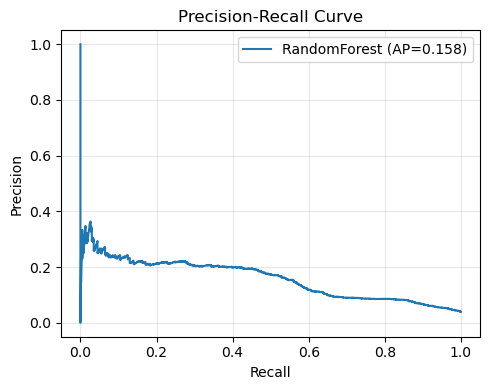


=== Baseline Leaderboard ===
            name    pr_auc   roc_auc
5  RandomForest  0.158067  0.799192
3           KNN  0.138796  0.772320
0        LogReg  0.132138  0.803140
4  DecisionTree  0.060008  0.578084
1       SVM_RBF  0.048070  0.527517
2    GaussianNB  0.041514  0.523968


In [17]:
scaled_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),('scaler', StandardScaler())])
tree_pipe = Pipeline([('imputer', SimpleImputer(strategy='median'))])

models = [('LogReg',       LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),'scaled'),
          ('SVM_RBF',      SVC(kernel='rbf', C=3.0, gamma='scale', probability=True, random_state=42),'scaled'),
          ('GaussianNB',   GaussianNB(), 'scaled'),
          ('KNN',          KNeighborsClassifier(n_neighbors=31, weights='distance'), 'scaled'),
          ('DecisionTree', DecisionTreeClassifier(max_depth=None, min_samples_split=10, class_weight='balanced', random_state=42), 'tree'),
          ('RandomForest', RandomForestClassifier(n_estimators=500, min_samples_leaf=2, class_weight='balanced_subsample', n_jobs=-1, random_state=42),'tree')]

pipe_map = {'scaled': scaled_pipe, 'tree': tree_pipe}
results = []

for name, clf, kind in models:
    pipe = Pipeline(pipe_map[kind].steps + [('clf', clf)])
    res = evaluate_model(name, pipe, X_train, y_train, X_valid, y_valid)
    results.append(res)

    model = res['model'] 
    if hasattr(model.named_steps['clf'], 'predict_proba'):
        y_score = model.predict_proba(X_valid)[:, 1]
    else:
        y_score = model.decision_function(X_valid)
    plot_pr_curve(y_valid, y_score, name)

leaderboard = pd.DataFrame(results).sort_values(['pr_auc','roc_auc'], ascending=False)
print('\n=== Baseline Leaderboard ===\n', leaderboard[['name','pr_auc','roc_auc']])

[ 결과 해석 ]

- 데이터는 극심한 불균형(양성 약 4%)
  - PR-AUC(AP)가 주지표 
    - PR 커브: 임계값을 바꾸며 그린 Precision(정밀도)–Recall(재현율) 곡선
    - 값이 클수록 전체 임계값 범위에서 정밀도와 재현율을 동시에 잘 유지했다는 뜻
  - ROC-AUC는 불균형에서 다소 낙관적이므로 보조지표로만 참고

- 모델별 요약 (검증 기준)
  - RandomForest — PR-AUC 0.158 (Top), ROC-AUC 0.799
    - 베이스라인(0.04)의 ~4배. 현재 셋업에서 가장 좋은 탐지력
    - 혼동행렬(임계값 0.5): precision≈0.17, recall≈0.52 → 양성 절반 정도를 잡지만 FP가 꽤 있음
    - 다음 단계: max_depth / max_features / min_samples_* / n_estimators 튜닝 + 임계값 조정
  - KNN — PR-AUC 0.139, ROC-AUC 0.772
    - 곡선(전체 임계값 범위)으로 보면 준수하지만, 0.5 임계값에선 recall≈0.005로 거의 못 잡음
    - 의미: 임계값을 낮추면? 더 괜찮아 질듯. n_neighbors/거리(metric) 튜닝 필요
  - LogReg — PR-AUC 0.132, ROC-AUC 0.803
    - AP는 KNN보다 조금 낮음
    - 0.5 임계값에서 recall≈0.77로 잘 잡지만 precision≈0.09 → FP가 매우 많음
    - 의미: 임계값을 올리면 precision↑, recall↓ 균형 가능할 것으로 추정. L2/L1(C) 튜닝 시도 필요
  - DecisionTree — PR-AUC 0.060, ROC-AUC 0.578
    - 단독 트리는 불안정/과적합 경향
  - SVM(RBF) — PR-AUC 0.048, ROC-AUC 0.528
    - 거의 무작위 수준. class_weight='balanced' 적용 + C/γ 튜닝 추가
  - GaussianNB — PR-AUC 0.042, ROC-AUC 0.524
    - 분포가 NB 가정과 맞지 않아? 극단적 예측(거의 전부 양성/음성)로 치우친 모습

In [21]:
xgb_pipe = Pipeline([('prep', preprocessor),
                     ('xgb', XGBClassifier(objective='binary:logistic', 
                                           eval_metric='aucpr',        # PR-AUC를 직접 최적화 (불균형에 적합)
                                           tree_method='hist',         # 빠른 트리 빌드(대용량에 유리)
                                           random_state=42, 
                                           n_estimators=600,           # 트리 개수
                                           learning_rate=0.05,         # 학습률 (낮을수록 보통 성능↑, 시간↑)
                                           subsample=0.8,              # 표본 서브샘플(과적합 완화)
                                           colsample_bytree=0.6,       # 특성 서브샘플(과적합 완화)
                                           max_depth=6,                # 트리 깊이(복잡도 조절)
                                           reg_alpha=0.0,              # L1 규제
                                           reg_lambda=1.0,             # L2 규제
                                           n_jobs=-1,
                                           scale_pos_weight=(y_train.value_counts()[0]/y_train.value_counts()[1])))]) # 불균형 보정

xgb_base_res = evaluate_model('XGBoost_base', xgb_pipe, X_train, y_train, X_valid, y_valid)

xgb_param_dist = {'xgb__n_estimators': [400, 600, 800, 1000],
                  'xgb__max_depth': [4, 6, 8],
                  'xgb__learning_rate': [0.03, 0.05, 0.08, 0.1],
                  'xgb__subsample': [0.7, 0.8, 0.9, 1.0],
                  'xgb__colsample_bytree': [0.5, 0.6, 0.7, 0.8],
                  'xgb__reg_alpha': [0.0, 0.1, 0.5, 1.0],
                  'xgb__reg_lambda': [0.5, 1.0, 2.0],
                  'xgb__min_child_weight': [1, 5, 10]}

xgb_search = RandomizedSearchCV(estimator=xgb_pipe,  param_distributions=xgb_param_dist, 
                                n_iter=25,  scoring='average_precision',
                                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                                n_jobs=-1,  verbose=1,  random_state=42,  refit=True)

xgb_search.fit(X_train, y_train)
print('Best params:', xgb_search.best_params_)
print('Best CV PR-AUC:', xgb_search.best_score_)

tuned_xgb = xgb_search.best_estimator_
tuned_xgb_res = evaluate_model('XGBoost_tuned', tuned_xgb, X_train, y_train, X_valid, y_valid)

[XGBoost_base] ROC-AUC: 0.8230 | PR-AUC: 0.1651
Confusion Matrix:
 [[12631  1971]
 [  248   354]]
              precision    recall  f1-score   support

           0     0.9807    0.8650    0.9193     14602
           1     0.1523    0.5880    0.2419       602

    accuracy                         0.8541     15204
   macro avg     0.5665    0.7265    0.5806     15204
weighted avg     0.9479    0.8541    0.8924     15204

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best params: {'xgb__subsample': 0.8, 'xgb__reg_lambda': 0.5, 'xgb__reg_alpha': 0.0, 'xgb__n_estimators': 400, 'xgb__min_child_weight': 5, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.03, 'xgb__colsample_bytree': 0.5}
Best CV PR-AUC: 0.18549557778729175
[XGBoost_tuned] ROC-AUC: 0.8435 | PR-AUC: 0.1796
Confusion Matrix:
 [[11946  2656]
 [  171   431]]
              precision    recall  f1-score   support

           0     0.9859    0.8181    0.8942     14602
           1     0.1396    0.7159    0.2337       60

- XGBoost_base: ROC-AUC 0.8230, PR-AUC 0.1651   
  XGBoost_tuned: ROC-AUC 0.8435, PR-AUC 0.1796      
→ PR-AUC가 +0.0145p (≈+9%) 개선되었고 ROC-AUC도 ↑

- Base: TP 354, FP 1,971 → 정밀도 0.152, 재현율 0.588   
  Tuned: TP 431, FP 2,656 → 정밀도 0.140, 재현율 0.716      
→ 양성 더 많이 포착(재현율↑) 했지만, 거짓 양성도 증가(정밀도↓) / 정확도는 오히려 하락   

In [22]:
lgb_pipe = Pipeline([('prep', preprocessor),
                     ('lgb', LGBMClassifier(objective='binary', 
                                            n_estimators=1500, 
                                            learning_rate=0.03, 
                                            subsample=0.8, 
                                            colsample_bytree=0.6, 
                                            num_leaves=63, 
                                            reg_alpha=0.0, 
                                            reg_lambda=1.0,
                                            random_state=42, 
                                            n_jobs=-1, 
                                            class_weight=None))])

lgb_base_res = evaluate_model('LightGBM_base', lgb_pipe, X_train, y_train, X_valid, y_valid)

lgb_param_dist = {'lgb__n_estimators': [800, 1200, 1600, 2000],
                  'lgb__learning_rate': [0.02, 0.03, 0.05, 0.08],
                  'lgb__num_leaves': [31, 63, 127, 255],
                  'lgb__min_child_samples': [5, 10, 20, 50],
                  'lgb__subsample': [0.7, 0.8, 0.9, 1.0],
                  'lgb__colsample_bytree': [0.5, 0.6, 0.7, 0.8],
                  'lgb__reg_alpha': [0.0, 0.1, 0.5, 1.0],
                  'lgb__reg_lambda': [0.5, 1.0, 2.0]}

lgb_search = RandomizedSearchCV(estimator=lgb_pipe, param_distributions=lgb_param_dist, n_iter=25, scoring='average_precision', 
                                n_jobs=-1, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                verbose=1, random_state=42, refit=True)
lgb_search.fit(X_train, y_train)
print('Best params:', lgb_search.best_params_)
print('Best CV PR-AUC:', lgb_search.best_score_)

tuned_lgb = lgb_search.best_estimator_
tuned_lgb_res = evaluate_model('LightGBM_tuned', tuned_lgb, X_train, y_train, X_valid, y_valid)

[LightGBM_base] ROC-AUC: 0.8214 | PR-AUC: 0.1613
Confusion Matrix:
 [[14583    19]
 [  598     4]]
              precision    recall  f1-score   support

           0     0.9606    0.9987    0.9793     14602
           1     0.1739    0.0066    0.0128       602

    accuracy                         0.9594     15204
   macro avg     0.5673    0.5027    0.4960     15204
weighted avg     0.9295    0.9594    0.9410     15204

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best params: {'lgb__subsample': 0.8, 'lgb__reg_lambda': 0.5, 'lgb__reg_alpha': 0.0, 'lgb__num_leaves': 31, 'lgb__n_estimators': 800, 'lgb__min_child_samples': 10, 'lgb__learning_rate': 0.02, 'lgb__colsample_bytree': 0.5}
Best CV PR-AUC: 0.19253434222155458
[LightGBM_tuned] ROC-AUC: 0.8474 | PR-AUC: 0.1828
Confusion Matrix:
 [[14597     5]
 [  600     2]]
              precision    recall  f1-score   support

           0     0.9605    0.9997    0.9797     14602
           1     0.2857    0.0033    0.0066   

- Base: ROC-AUC 0.8214, PR-AUC 0.1613   
  Tuned: ROC-AUC 0.8474, PR-AUC 0.1828    
  → 튜닝으로 PR-AUC가 +0.0215p(≈+13%) 개선

- Base: TP=4, FP=19, FN=598 → precision≈0.174, recall≈0.0066   
  Tuned: TP=2, FP=5, FN=600 → precision≈0.286, recall≈0.0033

In [ ]:
model = tuned_lgb_res['model']  
y_score = model.predict_proba(X_valid)[:, 1]
print("AP(valid):", average_precision_score(y_valid, y_score))

p, r, thr = precision_recall_curve(y_valid, y_score)
f1 = 2*p[:-1]*r[:-1] / (p[:-1]+r[:-1] + 1e-12)
t_star = thr[int(np.argmax(f1))] if len(thr) else 0.5
y_pred = (y_score >= t_star).astype(int)
print("Best F1 thr:", t_star)
print(confusion_matrix(y_valid, y_pred))
print(classification_report(y_valid, y_pred, digits=4, zero_division=0))

target_p = 0.20
mask = p[:-1] >= target_p
if mask.any():
    t_p20 = thr[mask][np.argmax(r[:-1][mask])]
    print("thr@P>=0.20:", t_p20)

AP(valid): 0.18283627466384691
Best F1 thr: 0.11812317501614032
[[13331  1271]
 [  281   321]]
              precision    recall  f1-score   support

           0     0.9794    0.9130    0.9450     14602
           1     0.2016    0.5332    0.2926       602

    accuracy                         0.8979     15204
   macro avg     0.5905    0.7231    0.6188     15204
weighted avg     0.9486    0.8979    0.9192     15204

thr@P>=0.20: 0.11563926383454604


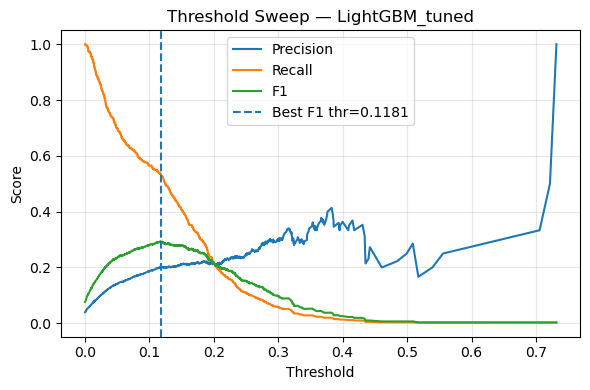

In [28]:
def plot_threshold_sweep(model, X_val, y_val, label='Model'):
    y_score = _get_score_from_pipeline(model, X_val)
    p, r, thr = precision_recall_curve(y_val, y_score)
    f1 = 2 * p[:-1] * r[:-1] / (p[:-1] + r[:-1] + 1e-12)
    best_idx = int(np.argmax(f1)) if len(f1) else None
    best_thr = thr[best_idx] if best_idx is not None else 0.5

    plt.figure(figsize=(6,4))
    plt.plot(thr, p[:-1], label='Precision')
    plt.plot(thr, r[:-1], label='Recall')
    plt.plot(thr, f1,     label='F1')
    plt.axvline(best_thr, linestyle='--', label=f'Best F1 thr={best_thr:.4f}')
    plt.xlabel('Threshold'); plt.ylabel('Score'); plt.title(f'Threshold Sweep — {label}')
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()
    return float(best_thr)

best_thr = plot_threshold_sweep(tuned_lgb_res['model'], X_valid, y_valid, label='LightGBM_tuned')

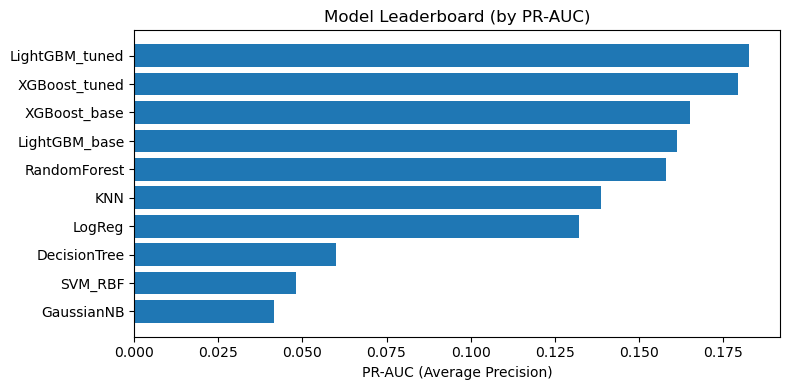

In [37]:
extra = []
for var in ['xgb_base_res', 'tuned_xgb_res', 'lgb_base_res', 'tuned_lgb_res']:
    if var in globals():
        extra.append(eval(var))

lb_df = pd.DataFrame(results + extra).drop_duplicates(subset='name')
lb_df = lb_df.sort_values('pr_auc', ascending=False)

plt.figure(figsize=(8, 4))
plt.barh(lb_df['name'], lb_df['pr_auc'])
plt.gca().invert_yaxis()
plt.xlabel('PR-AUC (Average Precision)')
plt.title('Model Leaderboard (by PR-AUC)')
plt.tight_layout()
plt.show()

=== ROC-AUC Leaderboard ===
              name   roc_auc    pr_auc
9  LightGBM_tuned  0.847411  0.182836
7   XGBoost_tuned  0.843493  0.179613
6    XGBoost_base  0.823050  0.165094
8   LightGBM_base  0.821432  0.161323
0          LogReg  0.803140  0.132138
5    RandomForest  0.799192  0.158067
3             KNN  0.772320  0.138796
4    DecisionTree  0.578084  0.060008
1         SVM_RBF  0.527517  0.048070
2      GaussianNB  0.523968  0.041514


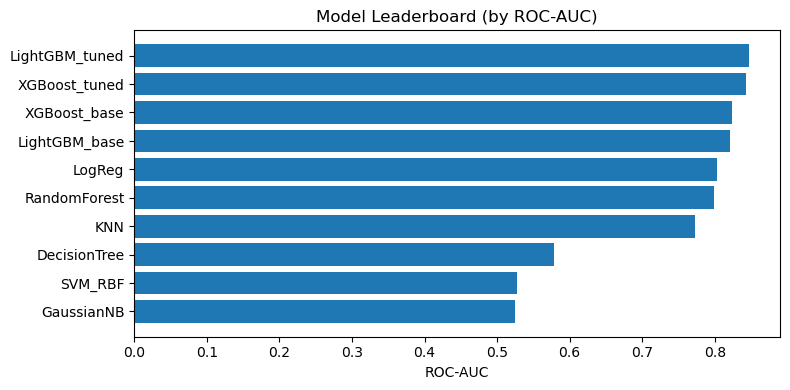

In [38]:
extra = []
for var in ['xgb_base_res', 'tuned_xgb_res', 'lgb_base_res', 'tuned_lgb_res']:
    if var in globals():
        extra.append(eval(var))

roc_df = pd.DataFrame(results + extra).drop_duplicates(subset='name')

roc_lb = roc_df.sort_values('roc_auc', ascending=False)
print('=== ROC-AUC Leaderboard ===\n', roc_lb[['name','roc_auc','pr_auc']])

plt.figure(figsize=(8,4))
plt.barh(roc_lb['name'], roc_lb['roc_auc'])
plt.gca().invert_yaxis()
plt.xlabel('ROC-AUC')
plt.title('Model Leaderboard (by ROC-AUC)')
plt.tight_layout()
plt.show()